In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from data.load_data import *
from sklearn.preprocessing import StandardScaler
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation
import seaborn as sns

In [2]:
cache = load_cache_behavior_neuropixel()

In [3]:
ecephys_sessions_table = cache.get_ecephys_session_table()
#example_session=ecephys_sessions_table.behavior_session_id[0:10].values.tolist()
# example_sessions=ecephys_sessions_table.index.values.tolist()
# len(example_sessions)

In [4]:
#making a list of sessions - selected for good range of unit locations and of behavior
example_sessions = [1053925378, 1081090969, 1064415305, 1108334384, 1115356973]
#choosing a session id and coding it as the variable session_id
session_id = example_sessions[2]

#get the info for this session
session = cache.get_ecephys_session(session_id)
# fun_key function to get the stimulus presentations we're interested in
trial_df = get_trial_df(session)
# extract behavioral variables for the trials we're interested in
behavior = make_behavior_table_active(session,trial_df)
#see what the behavior table looks like
print(session_id)


/root/capsule/code/data/load_data.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pres_df['image_int'] = pres_df.image_name.apply( lambda img: image_to_int[img] )


1064415305


In [5]:
#get continuous behavioral varaibles for each stim presentation
behavByStim = make_behavior_table_byStim(session,trial_df)
#get trial-related behavioral variables for each trial
behavior['Trials id']=behavior.index
#combine both of the above, to get full data for each stim presentation
fullData = pd.merge(behavByStim,behavior[['Trials id','Lick count','Rolling mean hit rate','Hit/miss this trial']],how='left',on='Trials id')
fullData.loc[fullData.Active==False,['Lick count','Rolling mean hit rate','Hit/miss this trial']]=np.nan
#convert to full data for each trial
trialData=fullData.groupby(np.arange(len(fullData))//4).mean()
# trialInds=trialData.index #will need these inds if doing HMM on full session

/root/capsule/code/data/load_data.py:123: RuntimeWarning: Mean of empty slice
  mean_speed = [np.nanmean(running_speed[np.logical_and(s1 <= running_time, running_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]
/root/capsule/code/data/load_data.py:128: RuntimeWarning: Mean of empty slice
  mean_pupil_area = [np.nanmean(pupil_area[np.logical_and(s1 <= pupil_time, pupil_time <= s2)]) for s1, s2 in zip(trial_start, trial_stop)]


In [6]:
#get smoothed versions of the continuous variables because they are noisy
trialData['Smoothed speed']=trialData['Mean speed'].rolling(5).mean()
trialData['Smoothed pupil']=trialData['Mean pupil area'].rolling(5).mean()
trialData.head(6) #now the first n-5 are NaN, where N is the rolling window set above
trialData.shape

(482, 9)

In [7]:
#active and passive
trialInds=trialData.index
print(trialData.head(6))

#split off a subset for active only
trialDataActive=trialData[trialData['Active']==True]
trialIndsA=trialDataActive.index #will need these inds if doing HMM on active only
print(trialDataActive.head(6))

#split off a subset for passive only
trialDataPassive=trialData[trialData['Active']==False]
trialIndsP=trialDataPassive.index
print(trialDataPassive.head(6))

   Active  Trials id  Mean speed  Mean pupil area  Lick count  \
0     1.0        4.0   35.436321      2275.358243         NaN   
1     1.0        8.0   32.130804      1902.741774         NaN   
2     1.0       12.0   47.754039      2069.637361         NaN   
3     1.0       19.0   40.929503      3249.128844         2.0   
4     1.0       20.0   49.968651      2881.664405         4.0   
5     1.0       21.0   45.543227      2771.730038         3.0   

   Rolling mean hit rate  Hit/miss this trial  Smoothed speed  Smoothed pupil  
0                    NaN                  NaN             NaN             NaN  
1                    NaN                  NaN             NaN             NaN  
2                    NaN                  NaN             NaN             NaN  
3                    NaN                  1.0             NaN             NaN  
4                    NaN                  1.0       41.243864     2475.706126  
5                    NaN                  1.0       43.265245   

Text(0.5, 0, 'trial')

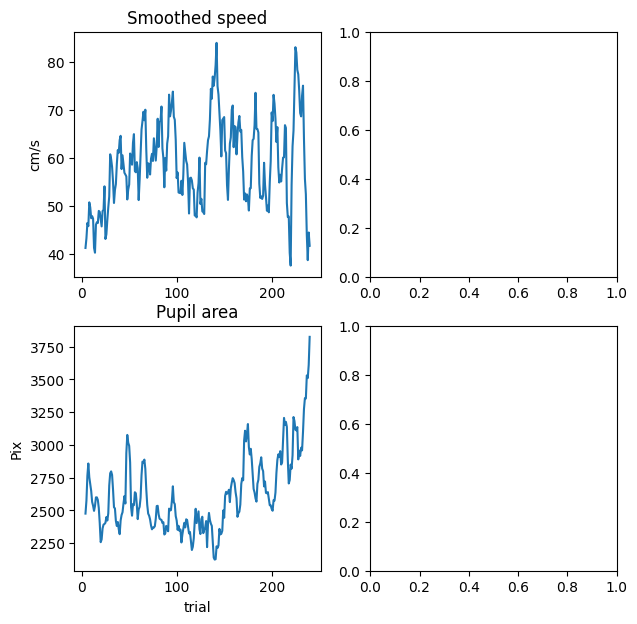

In [8]:
#visualize behavioral varaibles
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(7,7))
axes[0,0].plot(trialDataActive['Smoothed speed'])
axes[0,0].set_title('Smoothed speed')
axes[0,0].set_ylabel('cm/s')

axes[1,0].plot(trialDataActive['Smoothed pupil'])
axes[1,0].set_title('Pupil area')
axes[1,0].set_ylabel('Pix')
axes[1,0].set_xlabel('trial')

#axes[0,1].plot(trialDataActive['Lick count'])
#axes[0,1].set_title('Lick count')
#axes[0,1].set_ylabel('# licks')

#axes[1,1].plot(trialDataActive['Rolling mean hit rate'])
#axes[1,1].set_title('Hit rate')
#axes[1,1].set_ylabel('mean over 5 trials')
#axes[1,1].set_xlabel('trial')

In [9]:
#start coding the HMM for one session - load dynamax
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    if np.__version__ != '1.23.4':
        print('installing compatible numpy')
        %pip install -q numpy==1.23.4
    %pip install -q dynamax[notebooks]
    import dynamax
import warnings
warnings.filterwarnings("ignore")

In [10]:
# import jax
from functools import partial
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
from dynamax.utils.plotting import CMAP, COLORS, white_to_color_cmap

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [11]:
# organizing data for HMM
data = trialDataActive[['Smoothed speed', 'Smoothed pupil']].values
nInputs = len(data)

In [12]:
data[np.isnan(data)] = 0
observations = jnp.array(data)
observations_raw=observations.copy
scaler = StandardScaler()      
observations = scaler.fit_transform(observations)

In [13]:
# Split the data into equal length batches for cross-validation
n_batches = 6
n_steps = data.shape[0] - (data.shape[0] % n_batches)
batched_observations = observations[:n_steps, :].reshape(n_batches, -1, observations.shape[1])
batch_size = batched_observations.shape[1]
print("Number of batches:", n_batches)
print("Number of trials in each batch:", batch_size)

Number of batches: 6
Number of trials in each batch: 40


In [14]:
# Define empty lists that we'll populate below
avg_test_log_probs = []
all_test_log_probs = []
std_test_log_probs = []
similarity_of_states_across_batches = []
key = jr.PRNGKey(0) # <-- choose seed

for num_states in range(1, 6): # <--choose number of states
    print("num states: ", num_states)

    test_log_probs = []
    predicted_states = np.zeros([observations.shape[0], n_batches], dtype = int)
    
    for batch in range(n_batches):
        # Extract all but this batch for training
        train_observations = np.concatenate([batched_observations[:batch], batched_observations[batch+1:]])#.reshape((n_batches - 1)*batch_size, -1)
        flat_train_observations = train_observations.reshape((n_batches - 1) * batch_size, -1)
        
        if num_states == 1:
            print('fitting a single Gaussian')
            train_mean = jnp.mean(flat_train_observations, axis=0).reshape([1,2]) #change this based on number of parameters
            train_cov = jnp.cov(flat_train_observations.T)
            test_data = jnp.array(batched_observations[batch])#scaler.transform(jnp.array(batched_observations[batch]))
            test_lp = tfd.MultivariateNormalFullCovariance(train_mean, train_cov).log_prob(batched_observations[batch]).sum()
        else:
            # Make an HMM
            hmm = GaussianHMM(num_states, batched_observations.shape[2])
            
            params, param_props = hmm.initialize(key=key, method="kmeans", emissions=jnp.array(train_observations))

            # Fit the model
            params, lps = hmm.fit_em(params, param_props, jnp.array(train_observations), num_iters=500)
            
            #extract predicted states
            predicted_states[:,batch] = hmm.most_likely_states(params, observations)

            # Evaluate the log probability on held out data
            test_lp = hmm.marginal_log_prob(params, jnp.array(batched_observations[batch]))
        test_log_probs.append(test_lp)
        #lp_all.append(test_lp)
        #numstates_all.append(num_states)
    
    # Calculate the similarity of each set of predicted states
    if batch != 1:
        distance_between_batches = []
        for i in range(n_batches):
            for j in range(i-1):
                bestpermutation = find_permutation(predicted_states[:,i], predicted_states[:,j])
                distance_between_batches.append(np.sum(jnp.take(bestpermutation, predicted_states[:,i]) == predicted_states[:,j])/observations.shape[0])
        similarity_of_states_across_batches.append(np.mean(distance_between_batches))
    else:
        similarity_of_states_across_batches.append(1)
        
    # Store the average test log prob
    all_test_log_probs.append(test_log_probs)
    avg_test_log_probs.append(np.nanmean(test_log_probs))
    std_test_log_probs.append(np.nanstd(test_log_probs))

num states:  1
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
fitting a single Gaussian
num states:  2


num states:  3


num states:  4


num states:  5


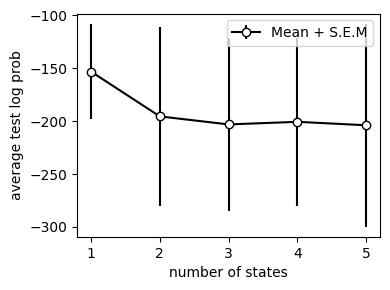

In [15]:
## keep these plots for all mice

plt.figure(figsize = (4, 3))
plt.errorbar(np.arange(1, 6), avg_test_log_probs, yerr = np.array(std_test_log_probs)/np.sqrt(n_batches), mfc = 'w', color = 'k', marker = 'o')

# If you like, you can plot up each of the log_probs from the session.
#for k, test_log_probs in zip(np.arange(1, 8), all_test_log_probs):
#    plt.plot(k * np.ones(n_batches), test_log_probs, 'r.')

plt.legend(['Mean + S.E.M'])
plt.xlabel("number of states")
plt.ylabel("average test log prob")
plt.tight_layout()

In [16]:
# replace the first four rows of the smoothed data with the non-smoothed data to avoid NANs
#trialDataActive[['Lick count','Smoothed speed', 'Smoothed pupil']].values

smothSpeedArray = trialDataActive['Smoothed speed'].values
smothPupilArray = trialDataActive['Smoothed pupil'].values
#lickCountArray=trialDataActive['Lick count'].values
smothSpeedArray[0:4]=trialDataActive['Mean speed'].values[0:4]
smothPupilArray[0:4]=trialDataActive['Mean pupil area'].values[0:4]
#lickCountArray[0:4]=0
input_data = np.vstack([smothSpeedArray,smothPupilArray]).T

input_data = scaler.fit_transform(input_data)
# input_data  = trialDataActive[['Lick count','Smoothed speed', 'Smoothed pupil']].values

In [17]:
#re-run the model haivg selected your number of states
best_num_states = 2

key = jr.PRNGKey(0)

number_of_states = best_num_states

final_hmm = GaussianHMM(best_num_states, input_data.shape[1], transition_matrix_stickiness=10.)

params, props = final_hmm.initialize(key=key, method="kmeans", emissions=input_data)

params, lps = final_hmm.fit_em(params, props, input_data, num_iters=500)

<AxesSubplot:>

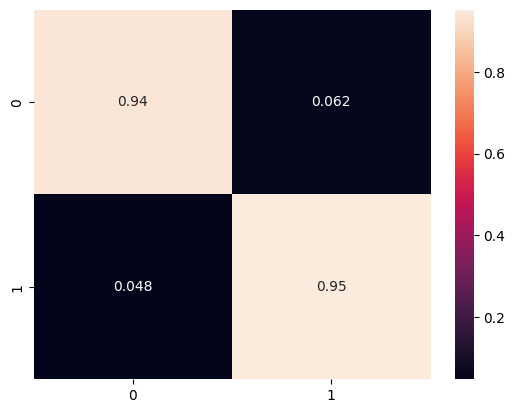

In [18]:
#plotting the learned transition matrix
sns.heatmap(np.squeeze(params.transitions), annot=True)

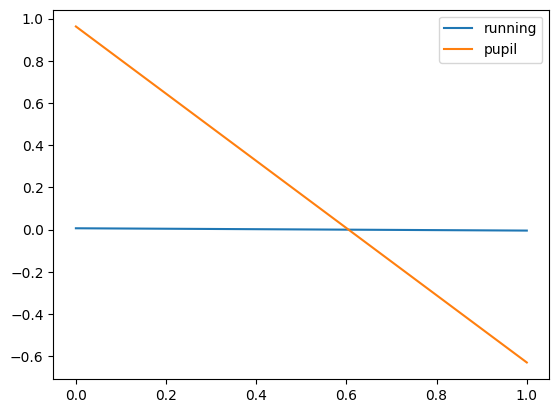

In [19]:
#plotting the means of the learned emission matrix where each state is a different line
#emission matrix is the n dimensional distribution you learned for each state.
#plt.plot(params.emissions.covs) #this will give covariance of the n dimensional distribution instead of means
plt.plot(params.emissions.means)#similar emission means will be comparable states across mice.
plt.legend(['running', 'pupil'])

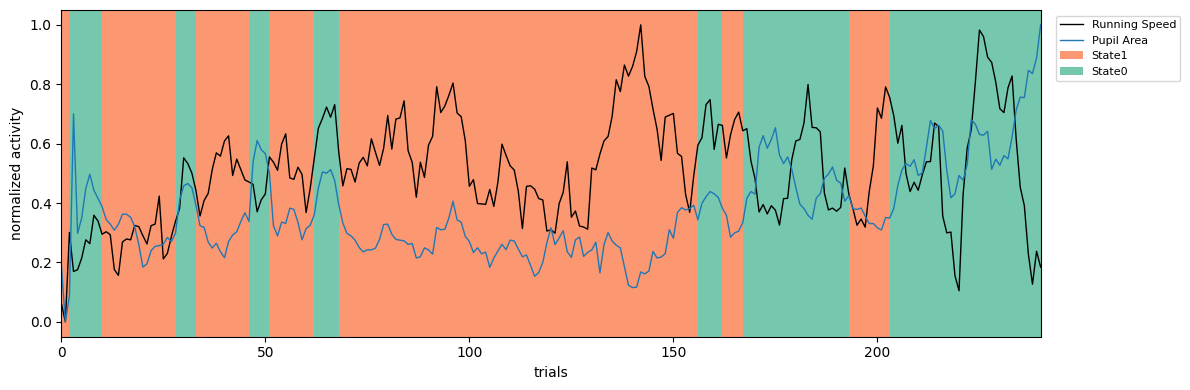

In [20]:
def minmax(x):
    # Function to normalize the data for easy visualization
    return (x - np.min(x))/(np.max(x) - np.min(x)) 

# Find the most likely discrete states given the learned model parameters
most_likely_states = final_hmm.most_likely_states(params, input_data)

# Overlay the precision and recall curves on top of the inferred states
fig, ax = plt.subplots(figsize=(12, 4))
cmap =sns.color_palette("Set2", best_num_states)
bounds=np.arange(-0.5, best_num_states, 0.5)

# Define state boundaries 
states = most_likely_states
switch_trials = np.where(np.diff(states))[0]
switch_trials = np.concatenate(([0], switch_trials, [len(trialIndsA)-1]))

# Plot the states 
for i, trial in enumerate(switch_trials[:-1]):
    for state_no in range(best_num_states):
        if states[trial+1] == state_no: 
            ax.axvspan(trialIndsA[trial], trialIndsA[switch_trials[i+1]], 
                       facecolor= cmap[state_no], alpha=0.9, label = 'State' + str(state_no))

# Overlay behavioral variables 
plt.plot(trialIndsA, minmax(trialDataActive['Smoothed speed']), color = 'black', label="Running Speed", lw = 1)
plt.plot(trialIndsA, minmax(trialDataActive['Smoothed pupil']), color = 'tab:blue', label="Pupil Area", lw = 1)
#plt.plot(trialIndsA, minmax(trialDataActive['Rolling mean hit rate']), color = 'blue', label="Hit rate", lw = 1)


# Formatting 
plt.xlim(trialIndsA[0], trialIndsA[-1])
plt.ylabel("normalized activity")
plt.xlabel("trials")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor = (1.01, 1), fontsize = 8)
plt.tight_layout()

In [21]:
trialData['state']=np.nan

In [22]:
trialData['state'][trialData['Active']==True]=most_likely_states

In [23]:
#get the assigned states for each trial and expand that to be for each stim presentation, by duplicating each trial's 
#assigned state 4 times in a row
#stateByStimPresentation = np.repeat(most_likely_states,4)
#make a new column in trial df, the dataframe of presentations that everyone shares. 
#alternatively, could do this for fullData above, or just export this as a standalone list or array
#start with the column as all NaNs, to that the passive state will fill in as NaNs
#trial_df['state']=np.nan

In [24]:
#for the stim presentations in the active session, replace NaN with the addigned state
#trial_df['state'][trial_df['active']==True]=stateByStimPresentation # for active only
#trial_df['state']=stateByStimPresentation
# alternative index that gives the same thing 
# trial_df['state'][0:stateByStimPresentation.shape[0]]=stateByStimPresentation

In [25]:
trialDataby4 = pd.DataFrame(np.repeat(trialData.to_numpy(), 4, axis=0), columns=trialData.columns)
trialDataby4.reset_index(inplace = True)

In [26]:
trial_df.reset_index(inplace = True)
#trial_df.head(1)

In [27]:
trial_df1 = pd.merge(trial_df, trialDataby4
                     [['Lick count', 'Rolling mean hit rate', 'Hit/miss this trial', 'Smoothed speed', 'Smoothed pupil', 'state']],on = trialDataby4.index.values, how= 'outer')
trial_df1

,key_0,stimulus_presentations_id,active,trials_id,start_time,end_time,image_int,image_name,Lick count,Rolling mean hit rate,Hit/miss this trial,Smoothed speed,Smoothed pupil,state
0,0,15,True,4,59.274591,59.524817,1,im036_r,NaN,NaN,NaN,NaN,NaN,1.0
1,1,16,True,4,60.025266,60.275458,1,im036_r,NaN,NaN,NaN,NaN,NaN,1.0
2,2,17,True,4,60.775841,61.026035,1,im036_r,NaN,NaN,NaN,NaN,NaN,1.0
3,3,18,True,4,61.526492,61.776720,1,im036_r,NaN,NaN,NaN,NaN,NaN,1.0
4,4,33,True,8,72.785931,73.036125,5,im083_r,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1923,1923,13326,False,690,8756.801563,8757.051775,4,im078_r,NaN,NaN,NaN,35.018618,3426.812716,NaN
1924,1924,13344,False,694,8770.312936,8770.563147,3,im047_r,NaN,NaN,NaN,36.154208,3600.401908,NaN
1925,1925,13345,False,694,8771.063557,8771.313762,3,im047_r,NaN,NaN,NaN,36.154208,3600.401908,NaN
1926,1926,13346,False,694,8771.814179,8772.064389,3,im047_r,NaN,NaN,NaN,36.154208,3600.401908,NaN


In [28]:
!pip install -q pyarrow

In [29]:
trial_df1.to_feather('../analysis_data/A1064415305.feather')